In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import hashlib

import dask
import xarray as xr
import xrspatial
from dask.diagnostics import ProgressBar
from geocube.api.core import make_geocube

import matplotlib.pyplot as plt
import seaborn as sns

PATH = "D:\World Bank\CLIENT v2"
DATA_RAW = rf"{PATH}\Data\Data_raw"
DATA_PROC = rf"{PATH}\Data\Data_proc"
DATA_OUT = rf"{PATH}\Data\Data_out"
GPW_PATH = rf"D:\Datasets\Gridded Population of the World"

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [29]:
# floods = pd.read_csv(rf"{DATA_RAW}\Floods\GloFAS_floods.csv")

def load_population_data(bounds=None, generate=False):
    print("Processing Population data...")

    # Select all files in GPW folder
    files = os.listdir(GPW_PATH)
    files = [f for f in files if f.endswith(".tif")]
    
    # Compile into a single dataset
    dss = []
    for f in tqdm(files):
        
        ds = xr.open_dataset(os.path.join(GPW_PATH, f), chunks={"x": 10000, "y": 10000})
        ds["band_data"] = ds["band_data"].astype(np.uint32)
        if bounds is not None:
            ds = ds.sel(
                x=slice(bounds[0], bounds[2]), y=slice(bounds[3], bounds[1])
            )
        if generate:
            with ProgressBar():
                ds.sel(band=1).drop_vars("band").band_data.rio.to_raster(rf"{DATA_PROC}\{f.replace('.tif','_proc.tif')}")
                print(f"Saved {f.replace('.tif','_proc.tif')}")
        
        ds["year"] = int(f.split("_")[5])
        ds = ds.set_coords('year')
        dss += [ds]
        
    population = xr.concat(dss, dim="year")    
    
    # Filter if bounds are provided
    if bounds is not None:
        population = population.sel(
            x=slice(bounds[0], bounds[2]), y=slice(bounds[3], bounds[1])
        )
        
    # Clean band dimension
    population = population.sel(band=1).drop_vars(["band"])
    
    print("Done!")
    return population

def load_precipitation_data():
    era5 = xr.open_dataset(
        rf"{DATA_OUT}\ERA5_monthly_1970-2021_SPI-SPEI.nc",
        chunks={"latitude": 100, "longitude": 100},
    )
    era5 = era5.rename({"latitude": "y", "longitude": "x"})
    return

def load_IPUMS_country_data():
    print("Loading IPUMS country data...")

    path = rf"{DATA_RAW}\IPUMS Fixed"
    files = os.listdir(path)
    geo2_files = [f for f in files if ".shp" in f and "geo2_" in f]
    geo2_countries = [name.split("_")[1] for name in geo2_files]
    geo1_files = [f for f in files if ".shp" in f and "geo1_" in f]
    geo1_files = [f for f in geo1_files if f not in geo2_countries]
    files = geo1_files + geo2_files

    gdfs = []
    for f in tqdm(files):
        gdfs += [gpd.read_file(os.path.join(path, f))]

    gdf = gpd.GeoDataFrame(pd.concat(gdfs))
    
    # Keep only relevant columns
    id_cols = ["CNTRY_CODE", "GEOLEVEL1", "GEOLEVEL2"] 
    gdf = gdf[["geometry"] + id_cols]
    
    for col in id_cols:
        gdf[col] = gdf[col].fillna(0)
    gdf = gdf[gdf.GEOLEVEL1 != 0] # Drop unavailable data
    
    assert gdf.duplicated(subset=id_cols).sum() == 0, "There are duplicated rows in the data!"
    
    # Create ID
    gdf["ID"] = gdf.groupby(id_cols).ngroup()
    assert gdf.ID.nunique() == gdf.shape[0], "ID is not unique!, there's some bug in the code..."
    print("Data loaded!")
    return gdf

def load_WB_country_data():
    print("Loading World Bank country data...")
    WB_country = gpd.read_file(rf"{DATA_RAW}\world_bank_adm2.zip")
    
    # Assign nan when ADM2 is not available 
    WB_country.loc[WB_country.ADM2_NAME == "Administrative unit not available", "ADM2_CODE"] = (
        np.nan
    )
    
    # Create ADM_LAST variable: ADM2_NAME if available, else ADM1_NAME
    for col in ["ADM0_CODE", "ADM1_CODE", "ADM2_CODE"]:
        WB_country[col] = WB_country[col].fillna(0)

    # Dissolve by ADM_LAST and country code
    WB_country = WB_country.dissolve(by=["ADM2_CODE","ADM1_CODE", "ADM0_CODE"]).reset_index()
    
    # # Create ID
    WB_country["ID"] = WB_country.groupby(["ADM2_CODE", "ADM1_CODE", "ADM0_CODE"]).ngroup()
    assert WB_country.ID.nunique() == WB_country.shape[0], "ID is not unique!, there's some bug in the code..."
    print("Data loaded!")
    return WB_country



def rasterize_shape_like_dataset(shape, dataset):
    print("Rasterizing shape...")
    raster = make_geocube(
        vector_data=shape,
        like=dataset,
    )
    # For some reason, like option is not working, so I have to manually add x and y
    assert (raster["x"].shape == dataset["x"].shape)
    assert (raster["y"].shape == dataset["y"].shape)
    raster["x"] = dataset["x"]
    raster["y"] = dataset["y"]
    raster = raster.drop_vars(["spatial_ref"])
    raster = raster.chunk({"x": 100, "y": 100})
    print("Done!")
    return raster


def process_era5_data():
   
    # Load ERA5 data
    
    # Create droughts dummies
    
    # Annualize series
    
    return

# Procesa IPUMS shapes

# Procesa WB/IPUMS shapes (administrative boundaries) y GPW (population data)

In [30]:
WB_country = load_WB_country_data()
IPUMS_country = load_IPUMS_country_data()
IPUMS_country = IPUMS_country.clip(WB_country.total_bounds)
population = load_population_data(bounds=WB_country.total_bounds)

Loading World Bank country data...
Data loaded!
Loading IPUMS country data...


100%|██████████| 169/169 [01:20<00:00,  2.10it/s]


Data loaded!
Processing Population data...


  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
 20%|██        | 1/5 [00:04<00:16,  4.14s/it]c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
c:\Users\ofici\

Done!


In [33]:
### Rasterize WB_country
WB_country_grid = rasterize_shape_like_dataset(
    WB_country[["ID", "geometry"]], 
    population
)

WB_country_path = rf"{DATA_PROC}\WB_country_grid.nc"
print("Saving WB_country_grid...")
with ProgressBar():
    WB_country_grid.to_netcdf(WB_country_path)
        
WB_country[["ID", "OBJECTID", "ADM2_CODE", "ADM1_CODE", "ADM0_CODE",  "geometry"]].to_feather(rf"{DATA_PROC}\WB_country_IDs.feather")


### Rasterize IPUMS_country
IPUMS_country_grid = rasterize_shape_like_dataset(
    IPUMS_country[["ID", "geometry"]], 
    population
)

IPUMS_country_path = rf"{DATA_PROC}\IPUMS_country_grid.nc"
print("Saving IPUMS_country_grid...")
with ProgressBar():
    IPUMS_country_grid.to_netcdf(WB_country_path)
        
IPUMS_country.to_feather(rf"{DATA_PROC}\IPUMS_country_IDs.feather")

# GENERA Base de droughts, sin interpolar

In [ ]:
import utils
droughts_path = rf"{DATA_OUT}\ERA5_droughts_yearly.nc"

In [ ]:
# if not os.path.exists(droughts_path):
print("Preparing droughts dataset...")
# Genera base de sequías
era5 = xr.open_dataset(rf"{DATA_OUT}\ERA5_monthly_1970-2021_SPI-SPEI.nc", chunks={'latitude': 1000, 'longitude': 1000})
# Corrije la dimensión x, que va de 0 a 360
era5 = era5.rename({'latitude': 'y', 'longitude': 'x'})
era5 = utils.coordinates_from_0_360_to_180_180(era5) # FIXME: no se si esto está andando bien, pero creo que si. VERIFICAR

# Calcula las sequías anuales
spi_yearly = era5.groupby("time.year").min()
with ProgressBar():
    spi_yearly.to_netcdf(rf"E:\client_v2_data\ERA5_yearly_1970-2021_SPI-SPEI.nc")

In [ ]:
spi_yearly = xr.open_dataset(rf"{DATA_PROC}\ERA5_yearly_1970-2021_SPI-SPEI.nc", chunks={"x": 900, "y": 1800})

spi_spei_vars = [var for var in spi_yearly.data_vars if "-" in var]
for var in spi_spei_vars:
    for threshold_str in ["1_0", "1_5", "2_0", "2_5"]:
        threshold = float(threshold_str.replace("_", "."))
        threshold_str = threshold_str.replace("_", "")
        spi_yearly[f"drought_{var}_{threshold_str}sd"] = (spi_yearly[var] < -threshold).astype("bool")

spi_yearly = spi_yearly[[var for var in spi_yearly.data_vars if "drought" in var]]
spi_yearly = spi_yearly.rename({
    var: var.replace("drought_", "").replace("-", "") for var in spi_yearly.data_vars
})
with ProgressBar():
    spi_yearly.to_netcdf(droughts_path)

# Huracanes

In [ ]:
## FIXED Parameters
sshws_min_wind = {
    # Saffir-Simpson Hurricane Wind Scale
    # Measured in knots
    # https://www.nhc.noaa.gov/aboutsshws.php
    5: 137,
    4: 113,
    3: 96,
    2: 83,
    1: 64,
}

agency_measurements = {
    "USA": 1, # 1-m measurement
    "TOK": 3, # 3-m measurement
    "CMA": 2, # 2-m measurement
    "HKO": 10, # 10-m measurement
    "KMA": 10,
    "NEW": 3,
    "REU": 10,
    "BOM": 10,
    "NAD": 10,
    "WEL": 10,
    "DS8": 1,
    "TD6": 1,
    "TD5": 1,
    "NEU": 1,
    "MLC": 1,
}

conversion_factor_to_1m = {
    1: 1,
    2: (1.22/1.15+1.17/1.11)/2,
    3: (1.22/1.12+1.17/1.09)/2,
    10: (1.22/1.06+1.17/1.05)/2,
}

agency_1m_conversion_factor = {
    k:conversion_factor_to_1m[v] for k, v in agency_measurements.items()
}

## Functions
def convert_wind_to_1m(wind, agency):
    if agency in agency_1m_conversion_factor:
        return wind * agency_1m_conversion_factor[agency]
    return wind

def convert_wind_to_sshws(wind):
    for cat, min_wind in sshws_min_wind.items():
        if wind >= min_wind:
            return cat
    return 0



In [ ]:
import geopandas as gpd

gdf = gpd.read_file(r"D:\Datasets\International Best Track Archive for Climate Stewardship (IBTrACS)\IBTrACS.ALL.list.v04r01.lines.shp")#, "BASIN", "SUBBASIN", "NAME", "ISO_TIME", "LAT", "LON", "WMO_WIND", "WMO_PRES", "WMO_AGENCY", "TRACK_TYPE"])

# Fill interpolated xy values
gdf["WMO_WIND"] = gdf["WMO_WIND"].ffill()

# Data from 1950 onwards
gdf["year"] = gdf["SEASON"].astype(int)
gdf = gdf[gdf["year"] >= 1970]

# Convert each Agency wind to 1m-MSW
wind_cols = [col for col in gdf.columns if "_WIND" in col and "WMO_WIND" not in col]
agencies = [col.replace("_WIND", "") for col in wind_cols]

for col in tqdm(wind_cols):
    agency = col.split("_")[0]
    gdf[col] = gdf[col].apply(lambda x: convert_wind_to_1m(x, agency))

gdf["wind_speed"] = gdf[wind_cols].max(axis=1)

# Convert wind to SSHWS category
gdf["category"] = gdf["wind_speed"].apply(convert_wind_to_sshws)

In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

buffers = [0.1, 0.25, 0.50, 1.00]
years = gdf["year"].unique()

paths_by_year = {}
for year in tqdm(years, leave=False):
    paths_by_year[year] = []
    for buffer in buffers:
        ### Filter year and create raster map based on the buffered best-track 
        ###     of the hurricane
        
        gdf_year = gdf[gdf.year == year]
        gdf_year = gdf_year[["wind_speed", "geometry"]]

        # Apply buffer to center of the storm
        gdf_year["geometry"] = gdf_year.geometry.buffer(buffer)
        
        # Make the biggest shock at a certain location the one shown in the xr.dataset 
        gdf_year = gdf_year.sort_values("wind_speed", ascending=True)
        raster = make_geocube(
            vector_data=gdf_year,
            like=population,
        )
        raster = raster.assign_coords({"year": year})

        for category in [1, 2, 3, 4, 5]:
            ### Once the raster wind_speed is created, create a new boolean raster 
            ###     where the winds are greater than the minimum for the category
            varname = f"category_{category}_b{int(buffer*100)}"
            # Keep only hurricanes of a certain category
            raster_b = xr.where(
                raster.rename({"wind_speed":varname})[varname] >= sshws_min_wind[category], 
                True, 
                False
            )
            # Transform wind_speed to boolean

            raster_path = rf"{DATA_PROC}\hurricanes\IBTrACS_{year}_{varname}.nc"
            raster_b.to_netcdf(raster_path, encoding={varname:{"zlib": True, "complevel": 7}})
            paths_by_year[year] += [raster_path]
            
        # xr.concat(dss, dim="year")


In [8]:
### Compile all the data into a single dataset
path = rf"{DATA_PROC}\hurricanes"
files = os.listdir(path)
dss = []
for year in range(1970, 2021):
    
    files_year = [os.path.join(path, f) for f in files if f"{year}" in f]
    dss += [xr.open_mfdataset(files_year, chunks={"x": 43200//2, "y": 17173//2})]

ds = xr.concat(dss, dim="year")
# encoding = {var: {"zlib":True, "complevel":5} for var in ds.data_vars}
with ProgressBar():
    ds.to_netcdf(r"D:\World Bank\CLIENT v2\Data\Data_out\IBTrACS_hurricanes_yearly.nc")

[########################################] | 100% Completed | 6hr 18m


In [ ]:
import ne

In [14]:
from netCDF4 import Dataset

nc = Dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\IBTrACS_hurricanes_yearly.nc")
# my_array = nc.variables['air'][:]
nc["category_1_b100"][1, 1, 1]

masked_array(data=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             mask=False,
       fill_value=999999,
            dtype=int8)

In [1]:
import xarray as xr
from dask.distributed import Client
from dask.diagnostics import ProgressBar
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 31.88 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55240,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 31.88 GiB
Comm: tcp://127.0.0.1:55259,Total threads: 1
Dashboard: http://127.0.0.1:55261/status,Memory: 7.97 GiB
Nanny: tcp://127.0.0.1:55243,


In [2]:
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\IBTrACS_hurricanes_yearly.nc", chunks={"x": 43200, "y": 17173, "time": 3})
ds["time"] = ds.year
ds =  ds.drop("year").rename({"time":"year"})
ds.to_netcdf(r"D:\World Bank\CLIENT v2\Data\Data_out\IBTrACS_hurricanes_yearly_corr.nc")

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\ofici\AppData\Local\Temp\ipykernel_2060\2438802292.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds =  ds.drop("year").rename({"time":"year"})


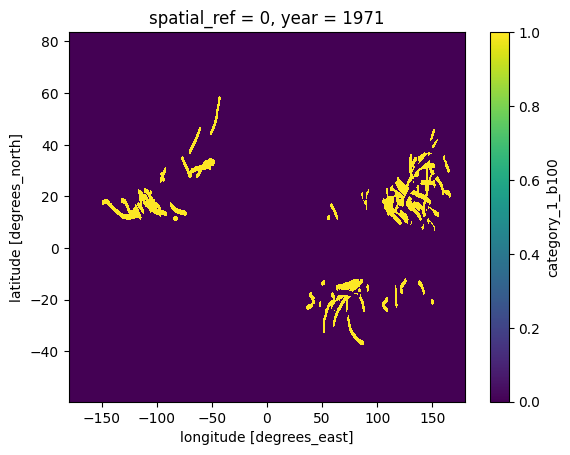

In [7]:
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_out\IBTrACS_hurricanes_yearly_corr.nc")
ds.sel(year=1971)["category_1_b100"].plot()

In [ ]:
import xarray as xr
xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1951_1.0.nc")["category_1_b1.0"].sel(x=slice(None, 0), y=slice(None, 0)).plot()